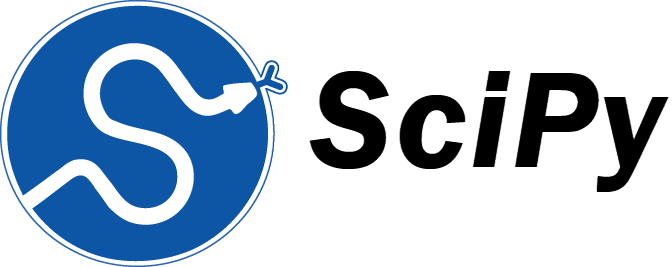

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# SciPy - A collection of scientific algorithms and data structures for Python

Much of this lecture is based on the excellent work of  J.R. Johansson who published his work here: 
J.R. Johansson (jrjohansson at gmail.com) [http://jrjohansson.github.io](http://jrjohansson.github.io).
Some examples have been pulled from https://github.com/scipy/scipy-cookbook/

The SciPy framework builds on top of the low-level NumPy framework for multidimensional arrays, and provides a large number of higher-level scientific algorithms. Some of the topics that SciPy covers are:

* Special functions ([scipy.special](http://docs.scipy.org/doc/scipy/reference/special.html))
* Integration and ODE  ([scipy.integrate](http://docs.scipy.org/doc/scipy/reference/integrate.html))
* Optimization ([scipy.optimize](http://docs.scipy.org/doc/scipy/reference/optimize.html))
* Interpolation ([scipy.interpolate](http://docs.scipy.org/doc/scipy/reference/interpolate.html))
* Fourier Transforms ([scipy.fftpack](http://docs.scipy.org/doc/scipy/reference/fftpack.html))
* Signal Processing ([scipy.signal](http://docs.scipy.org/doc/scipy/reference/signal.html))
* Linear Algebra ([scipy.linalg](http://docs.scipy.org/doc/scipy/reference/linalg.html))
* Sparse Eigenvalue Problems ([scipy.sparse](http://docs.scipy.org/doc/scipy/reference/sparse.html))
* Statistics ([scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html))
* Multi-dimensional image processing ([scipy.ndimage](http://docs.scipy.org/doc/scipy/reference/ndimage.html))
* File IO ([scipy.io](http://docs.scipy.org/doc/scipy/reference/io.html))

Each submodule in SciPy  provides a number of functions and classes that can be used to solve problems in their respective domain.


<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
#some code to help display things in this notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (11, 7.5)
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['legend.fontsize'] = 14


## Special functions

A large number of mathematical special functions are important for many computional physics problems. SciPy provides implementations of a very extensive set of special functions. For details, see the list of functions in the reference documention at http://docs.scipy.org/doc/scipy/reference/special.html#module-scipy.special. 

### Bessel Functions
To demonstrate the typical usage of special functions we will look in more detail at the Bessel functions
The `scipy.special` module includes a large number of Bessel-functions
Here we will use the functions $j_n$ and $y_n$, which are the Bessel functions 
of the first and second kind and real-valued order.

Bessel functions are a family of solutions to Bessel’s differential equation with real or complex order alpha:
$$
x^2 \frac{d^2 y}{dx^2} +x  \frac{dy}{dx} +(x^2−α^2)y=0
$$

Among other uses, these functions arise in wave propagation problems such as the vibrational modes of a thin drum head. Here is an example of a circular drum head anchored at the edge.

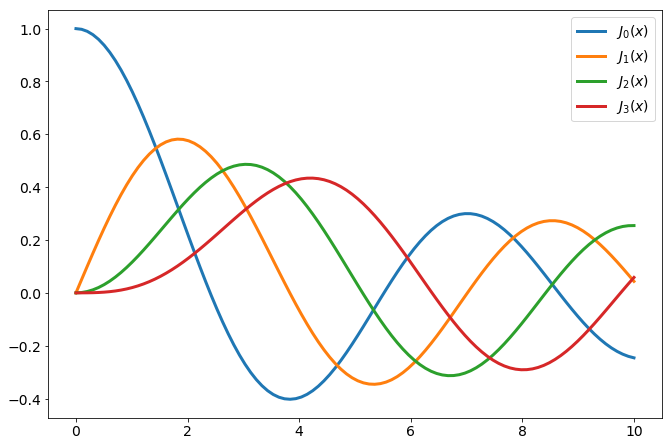

In [3]:
from scipy import special
x = np.linspace(0, 10, 100)

for n in range(4):
    plt.plot(x, special.jn(n, x), label=f'$J_{n}(x)$')
plt.legend();

In [4]:
# fix the radius of the drum
DRUM_RADIUS = 1

def drumhead_height(n, k, distance, angle, t):
    kth_zero = special.jn_zeros(n, k)[-1] # fix the drum on the outter edge to be zero.
    return np.cos(t) * np.cos(n*angle) * special.jn(n, distance*kth_zero/DRUM_RADIUS)

radius, theta = np.meshgrid(np.linspace(0, DRUM_RADIUS, 50), np.linspace(0, 2*np.pi, 50))
x = radius * np.cos(theta)
y = radius * np.sin(theta)
z = drumhead_height(1, 1, radius, theta, 0.5)

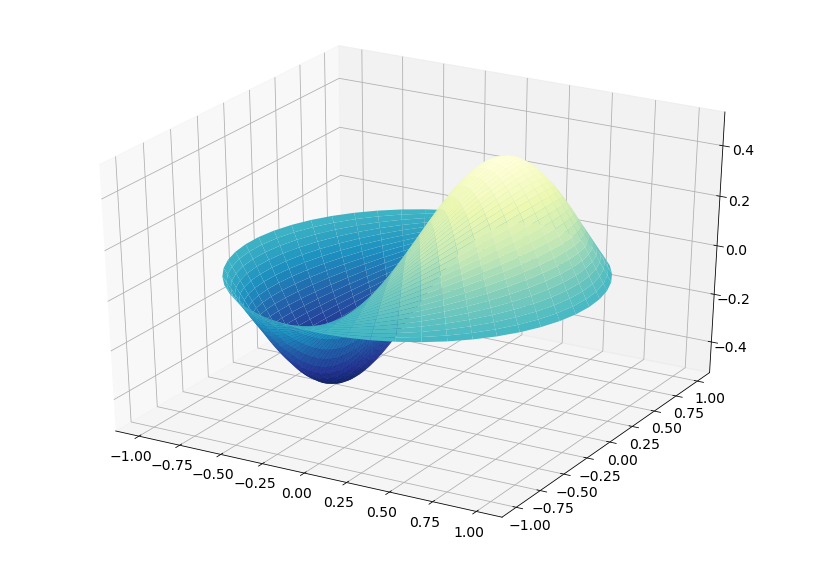

In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, z, cmap='YlGnBu_r')

### Polynomials

The module contains a large number of functions for evaluating polynomials and calculating their roots.

The following plot shows just a few of them.


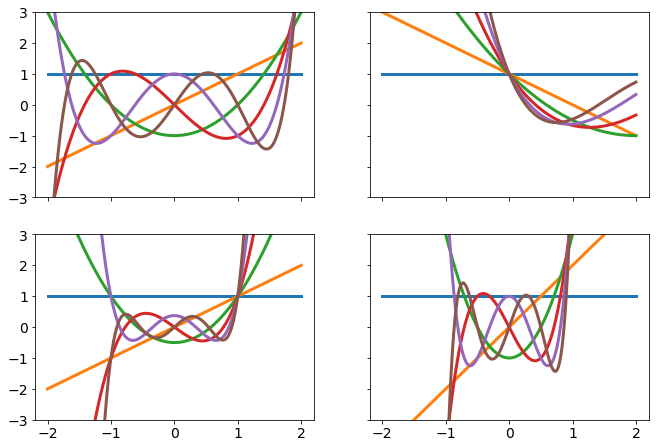

In [7]:
from scipy import special

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True )
for ax, p in zip(np.ravel(axs), [special.eval_chebys, special.eval_laguerre, special.eval_legendre, special.eval_chebyu]):
    x = np.linspace(-2., 2., 200)
    for n in range(6):
        ax.plot(x, p(n, x))
    ax.set_ylim([-3, 3])

### Statistical Functions

The module also contains a host of useful functions for statistical computations. for example the so called 'error function' `scipy.special.erf`

\begin{align}
\operatorname {erf}(x)&={\frac {1}{\sqrt {\pi }}}\int _{-x}^{x}e^{-t^{2}},dt \\ &={\frac {2}{\sqrt {\pi }}}\int _{0}^{x}e^{-t^{2}}\,dt.
\end{align}

Which allows you to get the gaussian probability dsitribution
$$
\phi(z) = \frac 1 2 \left(1 + erf\left(\frac{z}{sqrt(2)}\right) \right)
$$

The module `scipy.stats` contains nicer methods to handle statistical methods. More on that later.

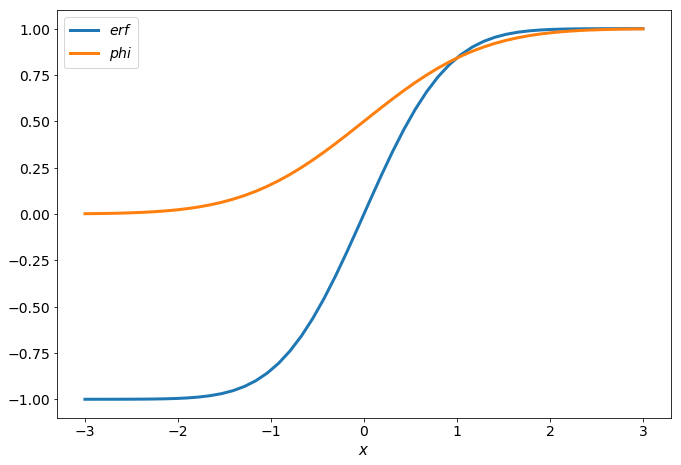

In [8]:
x = np.linspace(-3, 3)
plt.plot(x, special.erf(x), label='$erf$')
plt.plot(x, 0.5 * (1 + special.erf(x/np.sqrt(2))), label='$phi$')
plt.xlabel('$x$')
plt.legend()

## Ordinary Differential Equations.

To demonstrate the usefulness of SciPy lets try to predict what will happen to humanity in case of a zombie outbreak.  This example comes courtesy of Christopher Campo.

We will show that, in case of a Zombie outbreak, humanity is inevitably doomed. 
As shown by [Phillip Munz et al](http://mysite.science.uottawa.ca/rsmith43/Zombies.pdf) we can model a simple outbreak scenario like so.

\begin{align}
\frac{S}{dt} &= B - \beta S Z - \delta S \\
\frac{Z}{dt} &= \beta S Z + \gamma R - \alpha S Z \\
\frac{R}{dt} &= \delta S + \alpha S Z - \gamma R
\end{align}

Where $S$ is the number of susceptible humans, $Z$ is the number of zombies and $R$ is the number of removed persons which have died either by natural causes or zombie attack. The human birthrate is assumed to be constant and modeled by $B$

Susceptibles can become zombies through an encounter with a zombie ($\beta$). Natural causes of human deaths are parameterized by $\delta$. Humans in the removed class can be resurrected and become zombies ($\gamma$).  
Zombies can enter the removed class by cutting their heads of or removing their brains ($\alpha$)

The question I'm trying to answer is 

> __Can Humanity survive the zombie Apocalypse?__

Since I don't know how to solve differential equations, I'm going to use SciPy instead.


Now we use SciPy to solve this system of differential equations. The function `solve_ivp` does the entire job for us. 

If we go to [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) about this function we will read the following.


>This function numerically integrates a system of ordinary differential equations given an initial value:
>
> $y^{\prime} = f(t, y)$
>
>$y(t_0) = y_0$
>
>Here $t$ is a one-dimensional independent variable (time), $y(t)$ is an __n-dimensional vector-valued function__ (state), and an __n-dimensional vector-valued function f(t, y) determines the differential equations__. The goal is to find y(t) approximately satisfying the differential equations, given an initial value y(t0)=y0.


So we start by defining some starting values for the problem and the model function $f(t, y)$.

In [ ]:
from scipy.integrate import solve_ivp

# Type `solve_ivp?` to get inline documentation about the method in your notebook.
solve_ivp?

In [9]:
# fixed model parameters
B = 0.1 # birth rate
delta = 0.0001 # rate of natural casues of death
beta = 0.00016 # transmission coefficent
gamma = 0.0001 # resurrection rate
alpha = 0.0001 # rate of destroyed zombies

# initial conditions
S0 = 5000.              # initial population
Z0 = 0                 # initial zombie population
R0 = 0                 # initial dead population
y0 = [S0, Z0, R0]     # initial condition vector


def f_model(t, y):
    Si = y[0]
    Zi = y[1]
    Ri = y[2]
    # the model equations (see Munz et al. 2009)
    f0 = B - beta * Si * Zi - delta * Si
    f1 = beta * Si * Zi + gamma * Ri - alpha * Si * Zi
    f2 = delta * Si + alpha * Si * Zi - gamma * Ri
    return [f0, f1, f2]


Now we solve the equation and output the result

In [ ]:
t_start, t_end = 0, 100  # 100 days of zobie acopalypse
solution = solve_ivp(
    f_model,
    (t_start, t_end),
    y0,
    t_eval=np.linspace(t_start, t_end, 200),
)

In [ ]:
s = solution.y[0, :]
z = solution.y[1, :]
plt.plot(solution.t, s, label='survivors')
plt.plot(solution.t, z, label='zombies')
plt.legend()

### Exercise I:  ODE

Use SciPy `solve_ivp` method to numerically solve the following system of coupled differential euqations 

\begin{aligned}{{\dot {\theta }}_{1}}&={\frac {6}{ml^{2}}}{\frac {2p_{\theta _{1}}-3\cos(\theta _{1}-\theta _{2})p_{\theta _{2}}}{16-9\cos ^{2}(\theta _{1}-\theta _{2})}}\\{{\dot {\theta }}_{2}}&={\frac {6}{ml^{2}}}{\frac {8p_{\theta _{2}}-3\cos(\theta _{1}-\theta _{2})p_{\theta _{1}}}{16-9\cos ^{2}(\theta _{1}-\theta _{2})}}.
\end{aligned}

\begin{aligned}{{\dot {p}}_{\theta _{1}}}&={\frac {\partial L}{\partial \theta _{1}}}=-{\tfrac {1}{2}}ml^{2}\left({{\dot {\theta }}_{1}}{{\dot {\theta }}_{2}}\sin(\theta _{1}-\theta _{2})+3{\frac {g}{l}}\sin \theta _{1}\right)\\{{\dot {p}}_{\theta _{2}}}&={\frac {\partial L}{\partial \theta _{2}}}=-{\tfrac {1}{2}}ml^{2}\left(-{{\dot {\theta }}_{1}}{{\dot {\theta }}_{2}}\sin(\theta _{1}-\theta _{2})+{\frac {g}{l}}\sin \theta _{2}\right).
\end{aligned} 

Plot the results for the $\theta_1$ and $\theta_2$ using 

\begin{align}
x_1 &= L \; sin(\theta_1(t))\\
y_1 &= - L\;  cos(\theta_1(t)) \\
x_2 &= x_1 + L \; sin(\theta_2(t)) \\
y_2 &= y_1 - L \; cos(\theta_2(t))
\end{align}

Use 

\begin{align}
L &= 0.5 \mathrm{m} \\  
m &= 0.1 \mathrm{kg} \\
\theta_0 &= \pi/3 \\
\theta_1 &= -\pi/4 \\
p_0 &= 0 \\
p_1 &= 0.06 \, \mathrm{kg} \, \mathrm{m}/\mathrm{s}
\end{align}

In [ ]:
# %load solutions/scipy_solution_1.py
from scipy.constants import g

L = 0.5
m = 0.1


def pendulum_model(t, y):
    """
    The right-hand side of the pendulum ODE
    """
    theta_1, theta_2, p_1, p_2 = y[0], y[1], y[2], y[3]

    f1 = 6.0 / (m * L**2)

    dcos = np.cos(theta_1 - theta_2)
    dsin = np.sin(theta_1 - theta_2)

    denominator = 16 - 9 * dcos**2

    dtheta_1 = f1 * (2 * p_1 - 3 * dcos * p_2) / denominator
    dtheta_2 = f1 * (8 * p_2 - 3 * dcos * p_1) / denominator

    f2 = -0.5 * m * L**2
    dp_1 = f2 * ( dtheta_1 * dtheta_2 * dsin + 3 * (g / L) * np.sin(theta_1))
    dp_4 = f2 * (-dtheta_1 * dtheta_2 * dsin + (g / L) * np.sin(theta_2))

    return [dtheta_1, dtheta_2, dp_1, dp_4]


# initial values
y0 = [np.pi / 3, -np.pi / 4, 0, 0.065]
t_start, t_end = 0, 20

solution = solve_ivp(pendulum_model, (t_start, t_end), y0, t_eval=np.linspace(t_start, t_end, 1000))

x1s = + L * np.sin(solution.y[0])
y1s = - L * np.cos(solution.y[0])

x2s = x1s + L * np.sin(solution.y[1])
y2s = y1s - L * np.cos(solution.y[1])

plt.plot(x1s, y1s, '-')
plt.plot(x2s, y2s, '-', alpha=0.5)
plt.axis('off')
None


In [ ]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_ylim([-1.1, 0.2])
ax.set_xlim([1, -1])

pendulum1, = ax.plot([], [])
pendulum2, = ax.plot([], [])


def init():
    pendulum1.set_data([], [])
    pendulum2.set_data([], [])
    return (pendulum1, pendulum2)

def update(n):
    # update the line data
    pendulum1.set_data([0 ,x1s[n]], [0, y1s[n]])
    pendulum2.set_data([x1s[n], x2s[n]], [y1s[n], y2s[n]])
    return (pendulum1, pendulum2)


anim = animation.FuncAnimation(
    fig, update, init_func=init, frames=len(x1s),
    blit=True, interval=20,
)
anim.save('animation_ffmpeg.mp4', writer="ffmpeg", fps=50)


In [ ]:
%%HTML
<video controls>
  <source src="./animation_ffmpeg.mp4" type="video/mp4">
</video>

## Numerical Integration

### Numerical integration: quadrature

Numerical evaluation of a function of the type

$\displaystyle \int_a^b f(x) dx$

is called *numerical quadrature*, or simply *quadature*. SciPy provides a series of functions for different kind of quadrature, for example the `quad`, `dblquad` and `tplquad` for single, double and triple integrals, respectively.



In [ ]:
from scipy.integrate import quad, dblquad, tplquad

The `quad` function takes a large number of optional arguments, which can be used to fine-tune the behaviour of the function.

The basic usage is as follows:

In [ ]:
# define a simple function for the integrand
def f(x):
    return x**2

In [ ]:
x_lower = 0 # the lower limit of x
x_upper = 1 # the upper limit of x

val, abserr = quad(f, x_lower, x_upper)

print(f'integral value={val} , absolute error={abserr}' )

If we need to pass extra arguments to integrand function we can use the `args` keyword argument:

In [ ]:
def integrand(x, n):
    return special.jn(n, x)

x_lower = 0  # the lower limit of x
x_upper = 10 # the upper limit of x

val, abserr = quad(integrand, x_lower, x_upper, args=(3,))
print(val, abserr) 

For simple functions we can use a lambda function (name-less function) instead of explicitly defining a function for the integrand:

In [ ]:
f = lambda x: np.exp(-x ** 2)
val, abserr = quad(f, -np.Inf, np.Inf)

x = np.linspace(-4, 5, 200)
plt.plot(x, f(x))
plt.fill_between(x, f(x), alpha=0.2)
print(f'numerical= {val}, {abserr}')
print(f'analytical solution ={np.sqrt(np.pi)}')

As show in the example above, we can also use 'Inf' or '-Inf' as integral limits.

Higher-dimensional integration works in the same way:

In [ ]:
def integrand(x, y):
    return np.exp(-x**2-y**2)


x, y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
z = integrand(x, y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, z, cmap='YlGnBu')

val, abserr = dblquad(integrand, -2, 2, lambda x : -2, lambda x: 2)

print(f'numerical solution= {val}, {abserr}')

Note how we had to pass lambda functions for the limits for the y integration, since these in general can be functions of x.

### Exercise II:  Integrals and Special Functions

Find the circumference of an ellipse. The formula for calculating circumference $C$ is as follows.

$$
\frac{C}{4a} =  E(\epsilon)=\int _{0}^{\pi /2}{\sqrt {1-\epsilon^{2}\sin ^{2}\theta }}\ d\theta
$$

where $\epsilon$ is the eccentricity of the ellipse given by the length and width of the ellipse.

$$
\epsilon = \sqrt{1 - \frac{b^2}{a^2}}
$$

compare the solution found using `quad` with the appropriate function from the `scipy.special` package.

In [ ]:
# %load solutions/scipy_solution_2.py
a, b = .8, .4
epsilon = np.sqrt(1 - b**2/a**2)

t = np.linspace(0, 2*np.pi, 100)
plt.plot(a*np.cos(t), b*np.sin(t))
plt.xlim([-1, 1])
plt.ylim([-0.5, 0.5])
plt.gca().set_aspect(1)
plt.text(-0.2, 0, f'Ellipse with eccentrictiy: {epsilon:.4}')

circumference = 4 * a * special.ellipe(epsilon**2)

f = lambda t: 4*a* np.sqrt(1 - epsilon**2 * np.sin(t)**2)
val, abserr = quad(f, 0, np.pi/2)

print(f'numerical solution= {val}, {abserr}')
print(f'analytical solution= {circumference}')


## Signal Processing

SciPy offers a large amount of utilities to handle time series data. However the methods in the `scipy.signal` are useful for much more than just time series data.

In [10]:
from scipy import signal

## Convolution

The convolution of two continuos functions is defined by a simple integral transform.

\begin{aligned}
(f*g)(t)&\,{\stackrel {\mathrm {def} }{=}}\ \int _{-\infty }^{\infty }f(\tau )g(t-\tau )\,d\tau \\&=\int _{-\infty }^{\infty }f(t-\tau )g(\tau )\,d\tau .
\end{aligned}

Convolution happens whenever data gets smeared out by a detector or filter of any kind.

In [ ]:

# create two rectangular signals
f = np.repeat([0., 1., 0.], 120)
g = np.repeat([0., 1., 0.], 20)

result = signal.convolve(f, g)

In [ ]:
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(f, color='gray')
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(g, color='gray')
ax_win.arrow(70, 0.5, 50.0, 0.0, width=0.08, head_length=8)
ax_win.set_title('Filter impulse response')
ax_filt.plot(result)
ax_filt.set_title('Filtered signal')
None

The naive algorithm for producing discrete convolutions is not very efficient. It takes $\mathcal{O}(n^2)$ steps to get a result. SciPy uses a heuristic to automagically find the fastest convolution method. It is based on the *convolution theorem*

> The convolution theorem states that
>
 $$
 \mathcal{F}\{f*g\}=k\cdot {\mathcal {F}}\{f\}\cdot {\mathcal {F}}\{g\}
 $$
>
> where 
> $\mathcal {F}\{f\}$ denotes the Fourier transform of $f$, and $\mathcal {F}\{g\}$ the Fourier transform of $g$.
>
> https://en.wikipedia.org/wiki/Convolution

### Signal Windows

SciPy conveniently provides a handful of common signal windows ready to be used for convolution or other filtering operations. All of them can be found in `scipy.signal.window` but their are also available in the `scipy.signal` name space.

In [ ]:
for g in [signal.nuttall(50), signal.hann(50), signal.cosine(50), signal.triang(50), signal.blackman(50)]:
    plt.plot(g)
plt.axis('off')
None

### Correlation

The correlation of two functions $f$ and $g$ looks similar to a convolution 

> For continuous functions $f$ and $g$, the cross-correlation is defined as:
> 
$$
(f\star g)(\tau )\ {\stackrel {\mathrm {def} }{=}}\int _{-\infty }^{\infty }f^{*}(t)\ g(t+\tau )\,dt,
$$
> 
> where $f^{*}$ denotes the complex conjugate of  $f$, and $\tau$ is the displacement, also known as lag, although a positive value of $\tau$ actually means that $g(t+\tau)$ leads $f(t)$.

> *https://en.wikipedia.org/wiki/Cross-correlation*

The result of the correlation is a function of the delay $\tau$. This is useful for finding the offset in shifted signals.

In [ ]:
offset = 0.25
t = np.linspace(-1, 1, 600)
f = signal.gausspulse(t, fc=3)
g = signal.gausspulse( t + offset, fc=3)

result = signal.correlate(f, g, mode='same')
offset = t[np.argmax(result)]

In [ ]:
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2, width_ratios=[1, 1],)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[1, 0])
ax3 = plt.subplot(grid[:, 1], )

ax1.plot(t, f, color='gray')
ax1.set_title('$f$')
ax1.set_yticks([])

ax2.plot(t, g, color='gray')
ax2.set_title('$g$')
ax2.set_yticks([])

ax3.plot(t, result)
ax3.axvline(offset, color='xkcd:tangerine')
ax3.set_title('$(f\star g)(\\tau )$')
ax3.set_yticks([])
None

### Exercise III:  Signal Filtering

If we ever find an alien civilization we will have to communicate with them using binary encoded signals recorded by large radio telescopes.


Assuming the aliens use binary signals with 0s and 1s. 
Given the clock speed and the sample length with which the signal was created. Can you decode the following signal?

The plot below shows the shape of an example signal without any noise containing the message [0, 1 0]

In [ ]:
sample_length = 64
plt.plot(np.repeat([0, 1, 0], sample_length))
plt.text(25, 0.5, '0')
plt.text(100, 0.5, '1')
plt.text(175, 0.5, '0')

In [ ]:
alien_signal = np.genfromtxt('alien_signal.txt')
sample_length = 64
clock_speed = 32

plt.figure(figsize=(10, 2))
plt.plot(alien_signal, lw=1, alpha=0.5)

In [ ]:
# %load solutions/scipy_solution_3.py
# The clock speed gives us the points in time we need to sample the signal.
clock = np.arange(clock_speed, len(alien_signal), sample_length)

plt.figure()
plt.plot(alien_signal)
plt.plot(clock, alien_signal[clock], 'ro')


#Now cross correlate the signal with the pulse shape. We know the pulse shape and its length.

corr = signal.correlate(
    alien_signal,
    signal.boxcar(sample_length),
    mode='same'
) / sample_length

plt.figure()
plt.plot(corr)
plt.plot(clock, corr[clock], 'ro')
plt.axhline(0.5, ls='--', color='gray')


# decode the aline message
a = np.where(corr[clock] > 0.5, 1, 0)
s = bytearray(np.packbits(a)).decode('ascii')

print(f'Decoded Alien Message is:  "{s}" ')


## Fourier transform

Fourier transforms are one of the universal tools in computational physics, which appear over and over again in different contexts. SciPy provides functions for accessing the classic [FFTPACK](http://www.netlib.org/fftpack/) library, which is an efficient and well tested FFT library written in FORTRAN. The SciPy API has a few additional convenience functions, but overall the API is closely related to the original FORTRAN library.

To use the `fftpack` module in a python program, include it using:

In [101]:
from scipy import fftpack 

To demonstrate how to do a fast Fourier transform with SciPy, we will create some artificial data first.

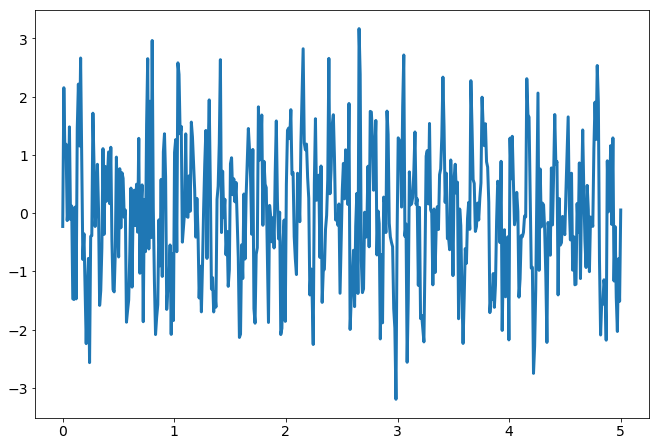

In [136]:
# Number of sample points
N = 500
L = 5
T = L / N

freqs = [8, 3, 32, 20, 40]
amps = [1.0, 0.5, 0.25, 0.3, 0.4]

x = np.linspace(0.0, L, N)
y = np.zeros_like(x)

for amp, freq in zip(amps, freqs):
    y += amp * np.sin(2.0 * np.pi * freq *x)

y = np.random.normal(y, 0.75, size=N,)

plt.plot(x, y)

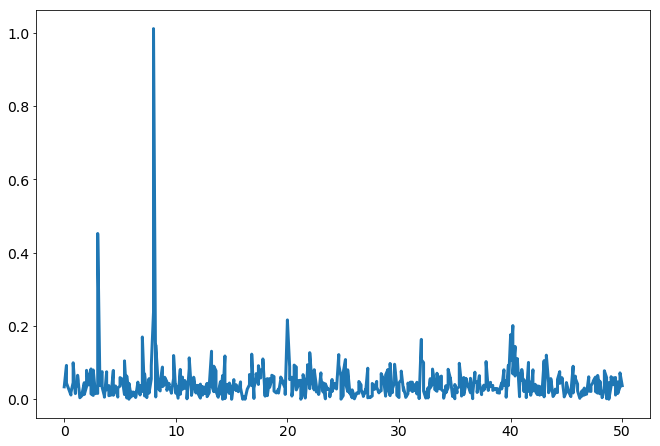

In [139]:
yf = fftpack.rfft(y)
xf = fftpack.rfftfreq(N, T)

power = 2.0 / N * np.abs(yf)

plt.plot(xf, power)


# plt.yscale('log')
# plt.xscale('log')

## Peakfinding

Let's find our frequencies

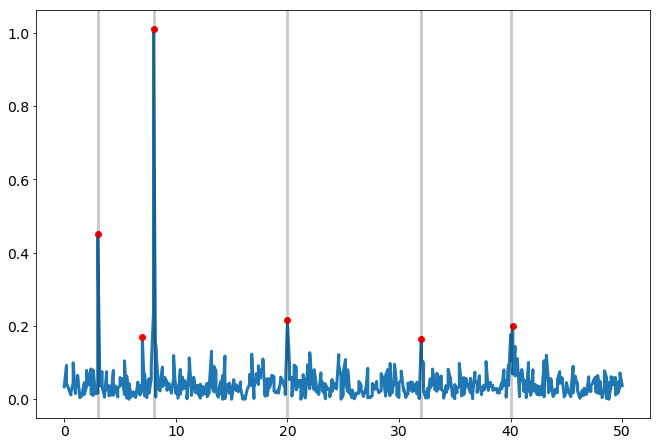

In [153]:
from scipy.signal import find_peaks

pos, properties = find_peaks(power, prominence=0.15)


plt.plot(xf, power)
plt.plot(xf[pos], power[pos], 'ro')


for freq in freqs:
    plt.axvline(freq, alpha=0.2, color='k')


## SciPy IO Module

### IO and the sound of hydrogen

SciPy provides some useful methods for reading file from MatLab, NetCDF or WAV data. Below is an example which uses the `scipy.io.wavfile` module to write a file containing the sound of hydrogen atoms.



In [ ]:
from scipy.io import wavfile
from scipy import signal

rate = 44100 #44.1 khz
duration = 10 # in sec

def rydberg(n, m):
    return (1/(n**2) -1/(m**2)) 

def lyman(m):
    return rydberg(1,m)

def balmer(m):
    return rydberg(2,m)

def sound(frequency, time):
    return 2**12*np.sin(2*np.pi*440*frequency*time)

t = np.linspace(0, duration, rate*duration)
hydrogen_sound = np.sum([sound(lyman(i), t) + sound(balmer(i), t) for i in range(2, 12)], axis=0)/6

plt.plot(t[:10000], hydrogen_sound[:10000])

wavfile.write('hydrogen.wav', rate, hydrogen_sound.astype(np.int16))

In [ ]:
%%HTML
<audio controls="controls" style="width:600px" >
  <source src="hydrogen.wav" type="audio/wav" />
</audio>

### Exercise IV:  Signal Processing and IO.

Load the file `synth_sound.wav` and plot a the frequency spectrum vs time.

In [ ]:
# %load solution_4.py

## Statistics

The `scipy.stats` module contains a large number of statistical distributions, statistical functions and tests. For a complete documentation of its features, see http://docs.scipy.org/doc/scipy/reference/stats.html.

Below we instantiate an object modeling a random variable following the normal distribution.

In [ ]:
from scipy import stats

mean = 0
sigma = 1
X = stats.norm(loc=mean, scale=sigma)

In [ ]:
N = 1200
measurments = X.rvs(size=N)
x = np.linspace(-3.5, 3.5, 200)

f, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))
ax1.hist(measurments, bins=40, density=True)
ax1.plot(x, X.pdf(x), color='red')


ax2.hist(measurments, bins=40, cumulative=True, density=True, )

ax2.plot(x, X.cdf(x), color='red')
None

In [ ]:
# create a (discreet) random variable with poissionian distribution
Y = stats.poisson(3.5) 

In [ ]:
n = np.arange(0, 15)

fig, axes = plt.subplots(2,1, sharex=True)

# plot the probability mass function (PMF)
axes[0].step(n, Y.pmf(n), where='mid')

# plot histogram of 1000 random realizations of the stochastic variable X
axes[0].hist(Y.rvs(size=100), density=True, bins=np.arange(16)  - 0.5);

# plot the commulative distribution function (CDF)
axes[1].step(n, Y.cdf(n), where='mid')
axes[1].hist(Y.rvs(size=100), cumulative=True, density=True, bins=np.arange(16)  - 0.5);

The objects support easy access to some of its statistical properties:

In [ ]:
print(X.mean(), X.std(), X.var()) # normal distribution
print(Y.mean(), Y.std(), Y.var()) # poission distribution

### Statistical tests

The module contains some usefull methods to perform statistical tests. 

Below we tests whether two sets of (independent) random data comes from the same distribution:

In [ ]:
# create two sets of data 
N = 500
a = X.rvs(size=N)
b = X.rvs(size=N)

plt.hist(a, bins=50, histtype='step', lw=4, density=True)
plt.hist(b, bins=50, histtype='step', lw=4, density=True)
t_statistic, p_value = stats.ttest_ind(a, b)

print(f't-statistic = {t_statistic}, p-value = {p_value}')

Since the p value is very large we cannot reject the hypothesis that the two sets of random data have *different* means.

## Linear algebra

The linear algebra module contains a lot of matrix related functions, including linear equation solving, eigenvalue solvers, matrix functions (for example matrix-exponentiation), a number of different decompositions (SVD, LU, cholesky), etc. 

Detailed documetation is available at: http://docs.scipy.org/doc/scipy/reference/linalg.html

Here we will look at how to use some of these functions:



### Linear equation systems

Linear equation systems on the matrix form

$A x = b$

where $A$ is a matrix and $x,b$ are vectors can be solved like:

In [ ]:
from scipy import linalg

In [ ]:
A = (np.arange(100) + np.random.normal(0, 10, size=(100))).reshape(10, 10)
b = np.array([0, 1 ,2 ,3 , 4, 5, 6, 7, 8, 9])

plt.matshow(A)
plt.grid()

In [ ]:
x = linalg.solve(A, b)
x

In [ ]:
# check
np.dot(A, x) - b

We can also do the same with

$A X = B$

where $A, B, X$ are matrices:

In [ ]:
A = np.random.rand(5,5)
B = np.random.rand(5,5)
f, [ax1, ax2] = plt.subplots(1, 2)
ax1.matshow(A)
ax2.matshow(B)
# plt.matshow(B)
ax1.grid()
ax2.grid()

In [ ]:
X = linalg.solve(A, B)
X

In [ ]:
# check
linalg.norm(np.dot(A, X) - B)

### Eigenvalues and eigenvectors

The eigenvalue problem for a matrix $A$:

$\displaystyle A v_n = \lambda_n v_n$

where $v_n$ is the $n$th eigenvector and $\lambda_n$ is the $n$th eigenvalue.

To calculate eigenvalues of a matrix, use the `eigvals` and for calculating both eigenvalues and eigenvectors, use the function `eig`. Both return complex numbers.

In [ ]:
A = np.random.rand(4, 4)

eigen_values = linalg.eigvals(A)
eigen_values

In [ ]:
values, vectors = linalg.eig(A)
values, vectors

There are also more specialized solvers, like the `eigh` for Hermitian matrices. 

### Exercise V:  Linear Algebra and Statistics

1.  Create a symmetric matrix $A$ with random entries which are distributed according to a normal distribution with a standard deviation of $\sigma = 10$ and a mean of $\mu = 0$. 

2. Draw a histogram of values in $A$. Get the maximum likelihood estimates for the standard deviation and mean from the values in $A$ and plot the curve for the normal distribution in the same plot using these values. Use `scipy.stats.norm`

3. Use $A$ to create a symmetric Matrix $A^\prime$ where the entries are distributed according to a $\chi^2$ distribution

4. Draw a histogram of values in $A^\prime$. Fit a $\chi^2$ distribution to the data using  `scipy.stats.chi2`


In [ ]:
# %load solutions/scipy_solution_5.py

## Optimization

Optimization (finding minima or maxima of a function) is a large field in mathematics, and optimization of complicated functions or in many variables can be rather complicated. Here we will only look at a few very simple cases. For a more detailed introduction to optimization with SciPy see: http://scipy-lectures.github.com/advanced/mathematical_optimization/index.html

To use the optimization module in scipy first include the `optimize` module:

In [ ]:
from scipy import optimize

### Finding Minima

Let's first look at how to find the minima of a simple function of a single variable:

In [ ]:
def f(x):
    return 4.5*x**3 + (x-4)**2 + 0.75*x**4 - 20

x = np.linspace(-6, 3, 100)
plt.plot(x, f(x));

We can use the `minimize_scalar` function to find the minima of a scalar function. It provides wrapper around many optimization algorithms you can choose from using the `method` keyword. 

In [ ]:
result = optimize.minimize_scalar(f)

plt.plot(x, f(x));
plt.plot(result.x, f(result.x), 'o', ms=15, mfc='none', mew=2)


# add some boundaries
result = optimize.minimize_scalar(f, bracket=[-6, -2])
plt.plot(result.x, f(result.x), 'o', ms=15, mfc='none', mew=2)

### Exercise VII Likelihood minimization

Imagine you have a sensor with 400 pixels. The pixel measure the number of photons in in a fixed length of time. Fit the mean of the photon cunts using the negative log likelihood of the poisson distribution

$$
X(k, \lambda) \; \sim \; \frac{\lambda^k}{k!} e^{-\lambda}
$$

In [ ]:
from scipy.stats import poisson

In [ ]:
true_lambda = 2
data = poisson.rvs(true_lambda, size=(20,20))
plt.imshow(data)
plt.grid()

In [ ]:
# %load solutions/scipy_solution_7.py
def negLogLikelihood(params, data):
    """ the negative log-Likelohood-Function"""
    lamb = params[0]
    lnl = - poisson.logpmf(data, lamb).sum()
    return lnl


# minimize the negative log-Likelihood
result = optimize.minimize(negLogLikelihood,  x0=[1], args=(data,))

print(result)

# plot poisson-deviation with fitted parameter
x_plot = np.arange(-1, 12)

plt.hist(data.ravel(), bins=np.arange(12) - 0.5, density=True,)
plt.step(x_plot, poisson.pmf(x_plot, result.x), where='mid', color='r', lw=2)


### Minimzation in more dimensions.

Below you'll find the infamous *Rosenbrock* function in two dimensions. It's very popular for benchmarking global optimization problems. Its solutions are well known and easily parametrized. 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def rosenbrock_2d(x, y, a=1, b=1):
    return (a - x)**2 + b*(y - x**2)**2


fig = plt.figure()
ax = Axes3D(fig)

x, y = np.meshgrid(np.linspace(-2 ,2, 100), np.linspace(-3. ,5, 100))
ax.plot_surface(x, y, rosenbrock_2d(x, y), cmap='magma_r')

In [ ]:
result = optimize.minimize(lambda x: rosenbrock_2d(x[0], x[1]), x0=[5, 2])
fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(20, 30)


x, y = np.meshgrid(np.linspace(-2 ,2, 100), np.linspace(-3. ,5, 100))
ax.plot_surface(x, y, rosenbrock_2d(x, y), cmap='magma_r', alpha=0.6)

x, y, z = result.x[0], result.x[1], 20
ax.quiver(x, y, z, 0, 0, -1, length=20, arrow_length_ratio=0.04)


result

### Least Squares Minimization

Lets presume a linear weighted combination of variables:

$$
f(x)= \hat{y} =  \hat{\beta}_0 + \sum_{j=1}^p x_j \hat{\beta}_j
$$
where $f:\mathbb{R}^{p} \to \mathbb{R}$.


When we include a 1 as the first entry into our sample $x$ e.g. $x = (1, x_1, x_2, \ldots, x_p)$ we can rewrite
$f$ in matrix form

$$
f(x)= \hat{y} =  x^T \mathbf{\beta}
$$

where $\beta = (\beta_0, \beta_1, \beta_2, \ldots, \beta_p)$.



How do you find those weights? Like before we choose a loss function and try to opimize it.
In this case we choose a loss function called the residual sum of squares (RSS).
We calculate it over all samples $x_i$ in a matrix $\mathbf{X}$.

$$L(\beta) = RSS(\mathbf{\beta}) = \sum_{i=1}^N (y_i - x_i^T \beta)^2 $$

Here $x_i$ is a row in $\mathbf{X}$, hence the transpose.

We can now rewrite the loss function in matrix form:


$$
RSS(\beta) = (\mathbf{y} - \mathbf{X} \beta)^T (\mathbf{y} - \mathbf{X} \beta )
$$

Now we optimize the loss function just like we would any other function, by differentiating with respect to $\beta$ and setting the result equals to zero.

$$
 \mathbf{X}^T (\mathbf{y} - \mathbf{X} \beta ) \stackrel{!}{=} 0
$$

Solving for $\beta$ leads to

$$
\hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$


We just performed  __Linear Least Squares__ regression. Below we fit some noisy a polynomial data.

In [ ]:
def f(x, beta=[4.5, 1, 0.75]):
    return beta[0]*x**3 + beta[1]*(x-4)**2 + beta[2]*x**4

x = np.linspace(-6, 3, 100)
data = f(x) + np.random.normal(0, 35, size=x.shape)

A = np.vstack([x**3, (x - 4)**2, x**4]).T

result = optimize.lsq_linear(A, data)
plt.plot(x, data, '.')
plt.plot(x, f(x), color='gray', label='truth')
plt.plot(x, f(x, beta=result.x), color='crimson', label='fit')

### Curve Fitting

For more general cases where the parameters are not linear there is the more convenient function `curve_fit`



In [ ]:
from scipy import stats


def f(t, a=5, tau=1, f=1):
    return a * np.exp(- t / tau) * np.sin(2 * np.pi * f * t)

x = np.linspace(0,  3, 100)
data = np.random.normal(f(x), 0.7)

popt, pcov = optimize.curve_fit(f, x, data, p0=[5, 4, ])

plt.plot(x, data, '.')
plt.plot(x, f(x), color='gray', label='truth')
plt.plot(x, f(x, *popt), color='crimson', label='fit')
plt.legend()
pcov

### Exercise VI:  Curve Fitting

Use `numpy.loadtxt` to load the file called `munich_temperatures_average.txt` and fit a model to it using `optimize.curve_fit`.



In [ ]:
# %load solution_6.py


### Root Finding

To find the solution for a function of the form $f(x) = 0$ we can use the `fsolve` or the `root` function. It requires one or more initial guesses: 

In [ ]:
def f(x):
    return 4.5*x**3 + (x-4)**2 + 0.75*x**4 - 20

x = np.linspace(-6, 3, 100)

plt.plot(x, f(x))
plt.axhline(color='black')

result = optimize.root(f, [-6, -3, 0, 2])
for r in result.x:
    plt.axvline(r, color='xkcd:tangerine')


## Interpolation

Interpolation is simple and convenient in scipy: The `interp1d` function, when given arrays describing X and Y data, returns and object that behaves like a function that can be called for an arbitrary value of x (in the range covered by X), and it returns the corresponding interpolated y value:

In [ ]:
from scipy import interpolate

def f(x):
    return np.sin(x)

In [ ]:
n = [0, 1, 2, 3, 3.5, 4, 6, 6.5, 7, 9]
x = np.linspace(0, 9, 100)

y_measured = f(n) 

linear_interpolation = interpolate.interp1d(n, y_measured)

cubic_interpolation = interpolate.interp1d(n, y_measured, kind='cubic')
# this returns a new function we can call for values of x
cubic_interpolation

In [ ]:
plt.plot(n, y_measured, 's', label='noisy data', color='black')
plt.plot(x, f(x), c='gray', lw=2, label='true function')
plt.plot(x, linear_interpolation(x), label='linear interpolation')
plt.plot(x, cubic_interpolation(x), label='cubic interpolation')
plt.legend();

## Sparse matrices

Sparse matrices are often useful in numerical simulations dealing with large systems, if the problem can be described in matrix form where the matrices or vectors mostly contains zeros. Scipy has a good support for sparse matrices, with basic linear algebra operations (such as equation solving, eigenvalue calculations, etc).

There are many possible strategies for storing sparse matrices in an efficient way. Some of the most common are the so-called coordinate form (COO), list of list (LIL) form,  and compressed-sparse column CSC (and row, CSR). Each format has some advantanges and disadvantages. Most computational algorithms (equation solving, matrix-matrix multiplication, etc) can be efficiently implemented using CSR or CSC formats, but they are not so intuitive and not so easy to initialize. So often a sparse matrix is initially created in COO or LIL format (where we can efficiently add elements to the sparse matrix data), and then converted to CSC or CSR before used in real calcalations.

For more information about these sparse formats, see e.g. http://en.wikipedia.org/wiki/Sparse_matrix

When we create a sparse matrix we have to choose which format it should be stored in. For example, 

In [ ]:
from scipy import sparse

In [ ]:
# dense matrix
M = np.array([[1,0,0,0], [0,3,0,0], [0,1,1,0], [1,0,0,1]]); M

In [ ]:
# convert from dense to sparse
A = sparse.csr_matrix(M)
A

In [ ]:
# convert from sparse to dense
A.todense()

More efficient way to create sparse matrices: create an empty matrix and populate with using matrix indexing (avoids creating a potentially large dense matrix)

In [ ]:
A = sparse.lil_matrix((4,4)) # empty 4x4 sparse matrix
A[0,0] = 1
A[1,1] = 3
A[2,2] = A[2,1] = 1
A[3,3] = A[3,0] = 1
A

In [ ]:
A.todense()

Converting between different sparse matrix formats:

In [ ]:
A

In [ ]:
A = sparse.csr_matrix(A); A

In [ ]:
A = sparse.csc_matrix(A); A

We can compute with sparse matrices like with dense matrices:

In [ ]:
A.todense()

In [ ]:
(A * A).todense()

In [ ]:
A.todense()

In [ ]:
A.dot(A).todense()

In [ ]:
v = np.array([1,2,3,4])[:,np.newaxis] 
v

In [ ]:
# sparse matrix - dense vector multiplication
A * v

In [ ]:
# same result with dense matrix - dense vector multiplcation
A.todense() * v